# Trim all the data and build the train and dev data frames 

In [126]:
import numpy as np
import pandas as pd

# constants determined from online source 
# r_0 on data sheet is specified to be < 100 mOhms
# r_0 = 0.037 # (ohms) 
q_nom = 3.350 # (Ah)
c_p = 1058 # (farads)
r_p = 0.039 # (ohms)

c = np.exp(-1 / (c_p * r_p))

In [127]:
# get the data paths 
import glob 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
sns.set()

data_paths = glob.glob('data/*/*/*.csv')

In [128]:
# function to build a data frame from a path and include filename, discharge temp, discharge profile
def path_to_df(path):
    df_new = pd.read_csv(path)
    
    # add discharge temp, discharge profile, and filename to the df columns 
    discharge_temp, discharge_profile, filename = path.split('/')[1:]
    df_new['data_path'] = path 
    df_new['discharge_temp'] = discharge_temp
    df_new['discharge_profile'] = discharge_profile 
    df_new['filename'] = filename 
    
    # check to make sure columns match expected columns 
    expected_columns = ['time_s', 'voltage_v', 'current_a', 'chargecapacity_ah', \
       'dischargecapacity_ah', 'charge_energy_wh', 'discharge_energy_wh', \
       'voltagedot_v_per_s', 'temp_degc', 'discharge_temp', \
       'discharge_profile', 'filename']
    
    for expected_column in expected_columns:
        if expected_column not in df_new.columns:
            print('missing column in {}'.format(path))
            raise
    
    return df_new

# function to downsample UDDS and US06 and trim the "charge and hold" sections of all profiles 
def trim_df(df):
    
    # downsample for UDDS and US06 profiles 
    if df['discharge_profile'].iloc[0] in ['UDDS', 'US06']:
        df = df_new.iloc[::10, :].reset_index(drop=True)
         
    # get first negative current index 
    first_neg_cur_idx = df.where(df["current_a"]<0).first_valid_index()
    
    # get last index of fully charged state (4.2V) 
    trim_idx = df.iloc[0:first_neg_cur_idx, :].where(df["voltage_v"]==4.2).last_valid_index()
    
    # slice dataframe from fully charged state to end 
    df = df.iloc[trim_idx+1:, :]
    
    # reset time index to begin from fully charged state 
    df = df.reset_index(drop=True).reset_index().drop(columns="time_s").rename(columns={"index": "time_s"}) 
    
    return df
    
# function to build state equations from known constants 
def build_df_states(df):
    n = df['current_a'].size
    
    # state variables 
    soc = np.zeros(n)
    v_p = np.zeros(n)
    
    # initial states 
    soc[0] = 100
    v_p[0] = 0 # redundant but good to note (is this a safe assumption?)
    
    for i in range(1, n):
        soc[i] = soc[i-1] - (-1) * (1 / (q_nom * 3600)) * df['current_a'].iloc[i-1] * 100
        v_p[i] = c * v_p[i-1] + (-1) * r_p * (1 - c) * df['current_a'].iloc[i-1] 
        
    df['soc'] = soc 
    df['v_p'] = v_p 
        
    return df

In [129]:
# build the train and dev sets 
dev_paths = ['data/T05/HPPC/5.csv', \
             'data/T35/US06/4.csv', 'data/T25/UDDS/1.csv']

df_train = pd.DataFrame() 
df_dev = pd.DataFrame() 

for data_path in data_paths:
    df_new = path_to_df(data_path)
    
    df_new = trim_df(df_new)
    
    df_new = build_df_states(df_new)
    
    if data_path in dev_paths:
        df_dev = df_dev.append(df_new)
    else:
        df_train = df_train.append(df_new)

df_train = df_train.reset_index()
df_dev = df_dev.reset_index()

# Model Training 

## Circuit Model: Calculate Voc (via plots) and R0 (via LS) 

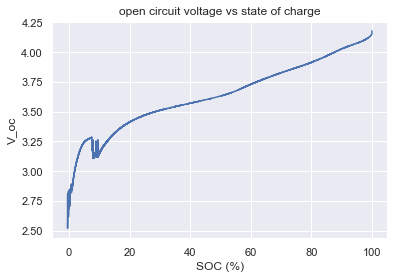

In [130]:
# calculate v_oc from 0_05C discharge profile -> V(SOC)
v_oc_levels = 1000
if (v_oc_levels % 10 != 0) or (v_oc_levels < 100):
    print('invalid number of bins specified for v_oc')
    raise

decimals = int(np.log(v_oc_levels / 100))

df_train['soc_rounded'] = df_train['soc'].round(decimals)
df_dev['soc_rounded'] = df_dev['soc'].round(decimals)

df_train_005C = df_train[df_train['discharge_profile'] == '0_05C']
v_oc = df_train_005C[['soc_rounded','voltage_v']].groupby('soc_rounded').mean()
v_oc = v_oc.rename(columns={"voltage_v": "v_oc"}).reset_index()

plt.plot(v_oc['soc_rounded'], v_oc['v_oc'])
plt.title('open circuit voltage vs state of charge')
plt.ylabel('V_oc')
plt.xlabel('SOC (%)')

if 'v_oc' in df_train.columns:
    df_train = df_train.drop(['v_oc'], axis=1)
if 'v_oc' in df_dev.columns:
    df_dev = df_dev.drop(['v_oc'], axis=1)

df_train = pd.merge(df_train, v_oc, how = 'left', on = 'soc_rounded')
df_dev = pd.merge(df_dev, v_oc, how = 'left', on = 'soc_rounded')

In [131]:
# calculate R0 using LS
A = np.zeros((df_train['current_a'].size,1))
A[:,0] = df_train['current_a']

y = np.zeros((df_train['voltage_v'].size,1))
y[:,0] = df_train['voltage_v']

b = np.zeros((df_train['voltage_v'].size,1))
b[:,0] = df_train['v_oc'] - df_train['v_p']

x = np.linalg.lstsq(A, y-b, rcond=None)
r_0 = x[0][0]
print('r_0 = {}'.format(r_0))

r_0 = [0.05055697]


## ML Models 

In [132]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

X_train = df_train[['data_path', 'current_a', 'soc']]
y_train = df_train[['data_path', 'voltage_v']]

X_dev = df_dev[['data_path', 'current_a', 'soc']]
y_dev = df_dev[['data_path', 'voltage_v']]

# Linear Regression 
print('fitting linear regression model')
model_reg = LinearRegression().fit(X_train[['current_a', 'soc']], y_train['voltage_v'])

# relu nn
print('fitting relu nn model')
model_nn_relu = MLPRegressor(solver='adam', activation = 'relu', alpha=1e-5, verbose = True, shuffle=True, \
                             hidden_layer_sizes=(8, 4, 2), random_state=1, learning_rate = 'adaptive',
                             n_iter_no_change=10, batch_size=200, early_stopping=False).fit(X_train[['current_a', 'soc']], y_train['voltage_v'])

# tanh nn
print('fitting tanh nn model')
model_nn_tanh = MLPRegressor(solver='adam', activation = 'tanh', alpha=1e-5, verbose = True, shuffle=True, \
                             hidden_layer_sizes=(8, 4, 2), random_state=1, learning_rate = 'adaptive',
                             n_iter_no_change=10, batch_size=200, early_stopping=False).fit(X_train[['current_a', 'soc']], y_train['voltage_v'])

fitting linear regression model
fitting relu nn model
Iteration 1, loss = 0.06994513
Iteration 2, loss = 0.00202894
Iteration 3, loss = 0.00200984
Iteration 4, loss = 0.00200159
Iteration 5, loss = 0.00197771
Iteration 6, loss = 0.00196780
Iteration 7, loss = 0.00196098
Iteration 8, loss = 0.00194889
Iteration 9, loss = 0.00194219
Iteration 10, loss = 0.00193400
Iteration 11, loss = 0.00193249
Iteration 12, loss = 0.00192321
Iteration 13, loss = 0.00191913
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
fitting tanh nn model
Iteration 1, loss = 0.19320439
Iteration 2, loss = 0.00170377
Iteration 3, loss = 0.00166262
Iteration 4, loss = 0.00164749
Iteration 5, loss = 0.00164598
Iteration 6, loss = 0.00163910
Iteration 7, loss = 0.00163626
Iteration 8, loss = 0.00163353
Iteration 9, loss = 0.00163295
Iteration 10, loss = 0.00163229
Iteration 11, loss = 0.00163182
Iteration 12, loss = 0.00163082
Iteration 13, loss = 0.00162923
Training loss did no

In [133]:
# Recurrent Neural Network 

import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Embedding
from keras import optimizers
from keras.callbacks import EarlyStopping

# function to convert dataframe data to windowed data that can be used by an RNN
# returns a numpy array 
def windowed_data(X, y, window_size):
    
    # lists to store each new row of data 
    X_windowed = []
    y_windowed = []
    
    # group X and y dataframe by data_path 
    X_grouped = X.groupby(X['data_path'])
    y_grouped = y.groupby(y['data_path'])
    
    # append rows to x and y data 
    for name, group, in X_grouped:
        X_windowed.append(windowed_data_helper(group[['current_a','soc']].values, window_size, True))
    
    for name, group in y_grouped:
        y_windowed.append(windowed_data_helper(group['voltage_v'].values, window_size, False))
        
    return np.vstack(X_windowed), np.vstack(y_windowed)

def windowed_data_helper(data, window_size, is_input):
    
    # need to create windowed data if input 
    if is_input:
        X_windowed = np.zeros((data.shape[0] - window_size + 1, window_size, data.shape[1]), dtype = 'float32')
        for sample_idx in range(0, data.shape[0] - window_size + 1):
            for feature_idx in range(0, data.shape[1]):
                X_windowed[sample_idx, :, feature_idx] = data[sample_idx:sample_idx + window_size, feature_idx]
                
        return X_windowed
    
    # need to leave out last window_size - 1 entries of output data 
    else:
        y_windowed = data[window_size-1:]
        y_windowed = y_windowed.reshape((y_windowed.shape[0],1))
        
        return y_windowed 

In [148]:
# fit a recurrent neural network 
print('windowing data')
lstm_window_size = 10
X_train_windowed, y_train_windowed = windowed_data(X_train, y_train, window_size = lstm_window_size)
X_dev_windowed, y_dev_windowed = windowed_data(X_dev, y_dev, window_size = lstm_window_size)

print('building lstm model')
model_lstm = Sequential()
model_lstm.add(LSTM(units=20, input_shape = (X_train_windowed.shape[1], X_train_windowed.shape[2]),
                    activation='tanh', recurrent_activation='sigmoid', use_bias=True, unit_forget_bias=True,
                    kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros',
                    kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                    kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, 
                    dropout=0.0, recurrent_dropout=0.0, implementation=1,
                    return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False))
model_lstm.add(Dense(units=1, activation=None, use_bias=False, 
                     kernel_initializer='glorot_uniform', bias_initializer='zeros', 
                     kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
                     kernel_constraint=None, bias_constraint=None))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

print('fitting lstm model')
es = EarlyStopping(monitor='val_loss', min_delta=0.000100, restore_best_weights=True)
model_lstm.fit(x=X_train_windowed, y=y_train_windowed, validation_data=[X_dev_windowed, y_dev_windowed], batch_size = 1024, epochs = 10, verbose=True, callbacks = [es])

windowing data
building lstm model
fitting lstm model
Train on 2554025 samples, validate on 56027 samples
Epoch 1/10
2554025/2554025 [==============================] - 193s 75us/step - loss: 0.2649 - val_loss: 7.1854e-04
Epoch 2/10
2554025/2554025 [==============================] - 177s 69us/step - loss: 0.0033 - val_loss: 6.9270e-04


# Model Testing 

In [135]:
# prediction results 
df_costs = pd.DataFrame(index = dev_paths, \
                        columns = ['circuit','reg','nn_relu','nn_tanh','lstm'])

## Circuit Testing

In [136]:
# Plot circuit results 
verbose = False
for dev_path in dev_paths:
    costs = pd.DataFrame(index = [df_dev['data_path'].unique()], columns = ['model'])

    voltage = pd.DataFrame.to_numpy(df_dev['voltage_v'][df_dev['data_path'] == dev_path])
    v_oc = pd.DataFrame.to_numpy(df_dev['v_oc'][df_dev['data_path'] == dev_path])
    v_p = pd.DataFrame.to_numpy(df_dev['v_p'][df_dev['data_path'] == dev_path])
    v_i = pd.DataFrame.to_numpy(df_dev['current_a'][df_dev['data_path'] == dev_path] * r_0)
    v_hat = v_oc - v_p - (-1) * v_i 
    
    cost = np.mean(np.power(voltage - v_hat,2))
    df_costs['circuit'].loc[dev_path] = cost 

    if verbose:
        # plot circuit model components, predictions, and error 
        fig=plt.figure(figsize=(18, 24))

        plt.subplot(3,1,1)
        plt.plot(v_oc)
        plt.plot(v_p)
        plt.plot((-1) * v_i)
        plt.title('circuit model components: {}'.format(dev_path))
        plt.legend(['v_oc', 'v_p', 'v_i'])

        plt.subplot(3,1,2)
        plt.plot(voltage)
        plt.plot(v_hat)
        plt.title('circuit model predictions: {}'.format(dev_path))
        plt.legend(['voltage', 'V_hat'])

        plt.subplot(3,1,3)
        plt.plot(voltage - v_hat)
        plt.title('circuit model errors: {}'.format(dev_path))

## ML Testing 

In [137]:
def ml_preds(model, X_dev, y_dev, df_cost, verbose = False, isLSTM = False, window_size = 10):
    for dev_path in y_dev['data_path'].unique():
        
        if isLSTM:
            print('windowing data') 
            X, y = windowed_data(X_dev[X_dev['data_path'] == dev_path],\
                                 y_dev[y_dev['data_path'] == dev_path],\
                                 window_size)     
        else:
            X = X_dev[['current_a','soc']][X_dev['data_path'] == dev_path].values
            y = y_dev['voltage_v'][y_dev['data_path'] == dev_path].values

        pred = model.predict(X).reshape(y.shape)
        
        cost = np.mean((pred - y) ** 2)
        df_cost.loc[dev_path] = cost 
        
        if verbose:
            fig=plt.figure(figsize=(18, 8))
            plt.plot(y)
            plt.plot(pred)
            plt.title(dev_path)
            plt.legend(['true voltage','predicted voltage'])

In [138]:
ml_preds(model_reg, X_dev, y_dev, df_costs['reg'])

In [139]:
ml_preds(model_nn_relu, X_dev, y_dev, df_costs['nn_relu'])

In [140]:
ml_preds(model_nn_tanh, X_dev, y_dev, df_costs['nn_tanh'])

In [149]:
ml_preds(model_lstm, X_dev, y_dev, df_costs['lstm'], isLSTM = True, window_size = lstm_window_size)

windowing data
windowing data
windowing data


# Plot Results

In [142]:
df_costs.drop(columns=['reg'], inplace=True)

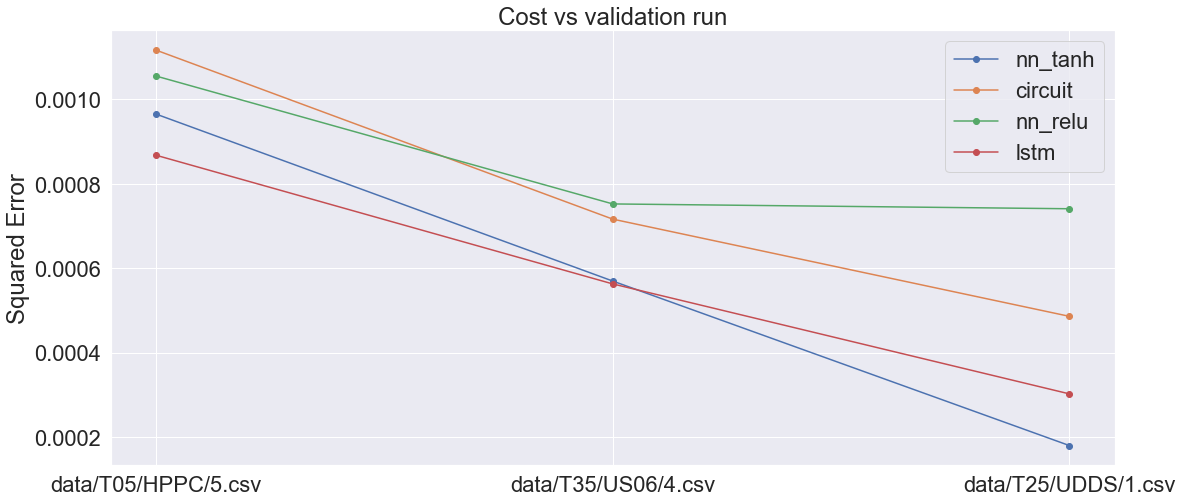

In [150]:
fig=plt.figure(figsize=(18, 8))
plt.title('Cost vs validation run');

plt.plot(df_costs, '-o');
plt.ylabel('Squared Error');
plt.legend(df_costs.columns);

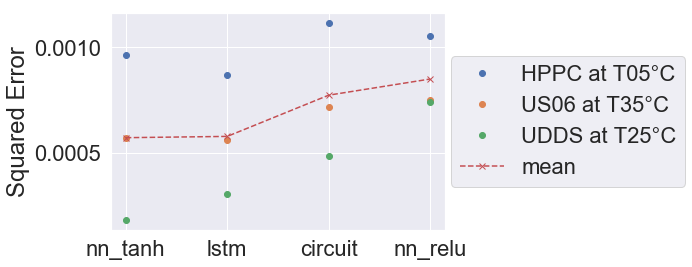

In [151]:
# plot means
sns.set(font_scale=2) # plot font size
fig, ax = plt.subplots()

df_costs = df_costs.reindex(df_costs.mean().sort_values().index, axis=1)
plt.plot(df_costs.transpose(), 'o');
plt.plot(df_costs.mean(), '--x')
labels = list(df_costs.index)
for label_idx in range(0, len(labels)):
    labels[label_idx] = labels[label_idx].split('/')[-2] + " at " + labels[label_idx].split('/')[-3] + "°C"
labels.append('mean')
plt.legend(labels, loc='center right', bbox_to_anchor=(1.75, 0.5), ncol=1)
plt.ylabel("Squared Error");

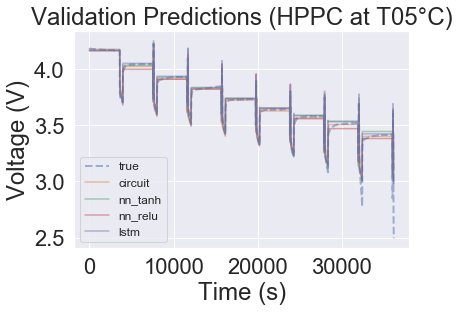

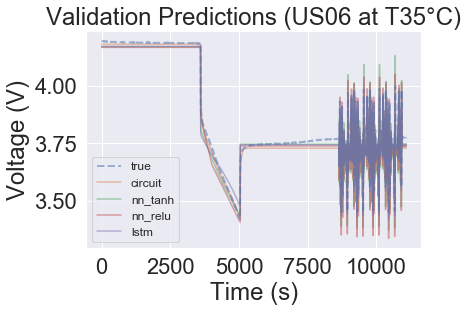

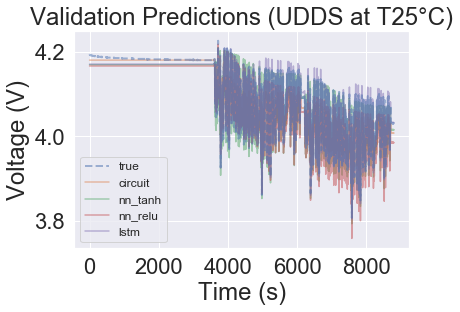

In [152]:
sns.set(font_scale=2) # plot font size
for dev_path in dev_paths:
    fig, ax = plt.subplots()
    
    # ground truth
    voltage = pd.DataFrame.to_numpy(df_dev['voltage_v'][df_dev['data_path'] == dev_path])
    plt.plot(voltage, label='true', linewidth=2, linestyle='dashed', zorder=10, alpha=0.5)
    
    # circuit model
    v_oc = pd.DataFrame.to_numpy(df_dev['v_oc'][df_dev['data_path'] == dev_path])
    v_p = pd.DataFrame.to_numpy(df_dev['v_p'][df_dev['data_path'] == dev_path])
    v_i = pd.DataFrame.to_numpy(df_dev['current_a'][df_dev['data_path'] == dev_path] * r_0)
    v_hat = v_oc - v_p - (-1) * v_i 
    plt.plot(v_hat, label='circuit', alpha=0.5)
    
    # linear regression
    X = X_dev[['current_a','soc']][X_dev['data_path'] == dev_path].values
    y = y_dev['voltage_v'][y_dev['data_path'] == dev_path].values
    #reg_pred = model_reg.predict(X).reshape(y.shape)
    #plt.plot(reg_pred, label='reg', alpha=0.5)
    
    # nn tanh
    tanh_pred = model_nn_tanh.predict(X).reshape(y.shape)
    plt.plot(tanh_pred, label='nn_tanh', alpha=0.5)
    
    # nn relu
    relu_pred = model_nn_relu.predict(X).reshape(y.shape)
    plt.plot(relu_pred, label='nn_relu', alpha=0.5)
    
    # lstm
    X, y = windowed_data(X_dev[X_dev['data_path'] == dev_path],
                         y_dev[y_dev['data_path'] == dev_path],
                         lstm_window_size)
    lstm_pred = model_lstm.predict(X).reshape(y.shape)
    lstm_pred_padded = np.concatenate((np.repeat(lstm_pred[0], lstm_window_size-1).reshape((lstm_window_size-1, 1)), lstm_pred), axis=0)
    plt.plot(lstm_pred_padded, label='lstm', alpha=0.5)

    # format plot nicely
    cycle = dev_path.split('/')[-2]
    temp = dev_path.split('/')[-3]
    clean_dev_path = cycle + " at " + temp + "°C"
    plt.title('Validation Predictions ({})'.format(clean_dev_path))
    plt.legend(loc='lower left', fontsize=12)
    #plt.legend(title='Model', loc='right', bbox_to_anchor=(1.75, 0.5), ncol=1)
    plt.ylabel('Voltage (V)')
    plt.xlabel('Time (s)')
    

In [146]:
dev_paths

['data/T05/HPPC/5.csv', 'data/T35/US06/4.csv', 'data/T25/UDDS/1.csv']

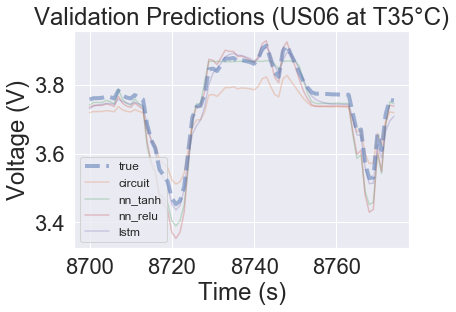

In [153]:
sns.set(font_scale=2) # plot font size
window_start = 8700
window_end = 8775
true_alpha = 0.5
other_alpha = 0.3
for dev_path in [dev_paths[1]]:
    fig, ax = plt.subplots()
    
    # ground truth
    voltage = pd.DataFrame.to_numpy(df_dev['voltage_v'][df_dev['data_path'] == dev_path])
    plt.plot(np.arange(window_start, window_end), voltage[window_start:window_end], label='true', linewidth=4, linestyle='dashed', zorder=10, alpha=true_alpha)
    
    # circuit model
    v_oc = pd.DataFrame.to_numpy(df_dev['v_oc'][df_dev['data_path'] == dev_path])
    v_p = pd.DataFrame.to_numpy(df_dev['v_p'][df_dev['data_path'] == dev_path])
    v_i = pd.DataFrame.to_numpy(df_dev['current_a'][df_dev['data_path'] == dev_path] * r_0)
    v_hat = v_oc - v_p - (-1) * v_i 
    plt.plot(np.arange(window_start, window_end), v_hat[window_start:window_end], label='circuit', alpha=other_alpha)
    
    # linear regression
    X = X_dev[['current_a','soc']][X_dev['data_path'] == dev_path].values
    y = y_dev['voltage_v'][y_dev['data_path'] == dev_path].values
    #reg_pred = model_reg.predict(X).reshape(y.shape)
    #plt.plot(np.arange(window_start, window_end), reg_pred[window_start:window_end], label='reg', alpha=other_alpha)
    
    # nn tanh
    tanh_pred = model_nn_tanh.predict(X).reshape(y.shape)
    plt.plot(np.arange(window_start, window_end), tanh_pred[window_start:window_end], label='nn_tanh', alpha=other_alpha)
    
    # nn relu
    relu_pred = model_nn_relu.predict(X).reshape(y.shape)
    plt.plot(np.arange(window_start, window_end), relu_pred[window_start:window_end], label='nn_relu', alpha=other_alpha)
    
    # lstm
    X, y = windowed_data(X_dev[X_dev['data_path'] == dev_path],
                         y_dev[y_dev['data_path'] == dev_path],
                         lstm_window_size)
    lstm_pred = model_lstm.predict(X).reshape(y.shape)
    lstm_pred_padded = np.concatenate((np.repeat(lstm_pred[0], lstm_window_size-1).reshape((lstm_window_size-1, 1)), lstm_pred), axis=0)
    plt.plot(np.arange(window_start, window_end), lstm_pred_padded[window_start:window_end], label='lstm', alpha=other_alpha)

    # format plot nicely
    cycle = dev_path.split('/')[-2]
    temp = dev_path.split('/')[-3]
    clean_dev_path = cycle + " at " + temp + "°C"
    plt.title('Validation Predictions ({})'.format(clean_dev_path))
    plt.legend(loc='lower left', fontsize=12)
    #plt.legend(title='Model', loc='right', bbox_to_anchor=(1.75, 0.5), ncol=1)
    plt.ylabel('Voltage (V)')
    plt.xlabel('Time (s)')

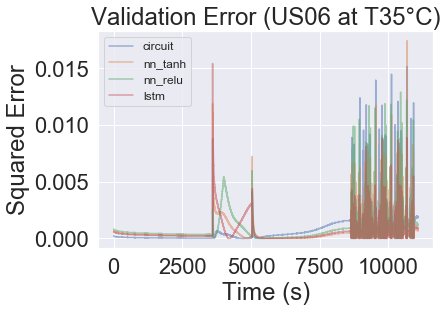

In [174]:
sns.set(font_scale=2) # plot font size
for dev_path in [dev_paths[1]]:
    fig, ax = plt.subplots()
    
    # ground truth
    voltage = pd.DataFrame.to_numpy(df_dev['voltage_v'][df_dev['data_path'] == dev_path])
    #plt.plot(voltage, label='true', linewidth=2, linestyle='dashed', zorder=10, alpha=0.5)
    
    # circuit model
    v_oc = pd.DataFrame.to_numpy(df_dev['v_oc'][df_dev['data_path'] == dev_path])
    v_p = pd.DataFrame.to_numpy(df_dev['v_p'][df_dev['data_path'] == dev_path])
    v_i = pd.DataFrame.to_numpy(df_dev['current_a'][df_dev['data_path'] == dev_path] * r_0)
    v_hat = v_oc - v_p - (-1) * v_i 
    plt.plot(np.power(voltage - v_hat, 2), label='circuit', alpha=0.5)
    
    # linear regression
    X = X_dev[['current_a','soc']][X_dev['data_path'] == dev_path].values
    y = y_dev['voltage_v'][y_dev['data_path'] == dev_path].values
    #reg_pred = model_reg.predict(X).reshape(y.shape)
    #plt.plot(reg_pred, label='reg', alpha=0.5)
    
    # nn tanh
    tanh_pred = model_nn_tanh.predict(X).reshape(y.shape)
    plt.plot(np.power(voltage - tanh_pred, 2), label='nn_tanh', alpha=0.5)
    
    # nn relu
    relu_pred = model_nn_relu.predict(X).reshape(y.shape)
    plt.plot(np.power(voltage - relu_pred, 2), label='nn_relu', alpha=0.5)
    
    # lstm
    X, y = windowed_data(X_dev[X_dev['data_path'] == dev_path],
                         y_dev[y_dev['data_path'] == dev_path],
                         lstm_window_size)
    lstm_pred = model_lstm.predict(X)
    lstm_pred_padded = np.concatenate((np.repeat(lstm_pred[0], lstm_window_size-1).reshape((lstm_window_size-1, 1)), lstm_pred), axis=0).reshape(voltage.shape)
    plt.plot(np.power(voltage - lstm_pred_padded, 2), label='lstm', alpha=0.5)

    # format plot nicely
    cycle = dev_path.split('/')[-2]
    temp = dev_path.split('/')[-3]
    clean_dev_path = cycle + " at " + temp + "°C"
    plt.title('Validation Error ({})'.format(clean_dev_path))
    plt.legend(loc='upper left', fontsize=12)
    #plt.legend(title='Model', loc='right', bbox_to_anchor=(1.75, 0.5), ncol=1)
    plt.ylabel('Squared Error')
    plt.xlabel('Time (s)')
    

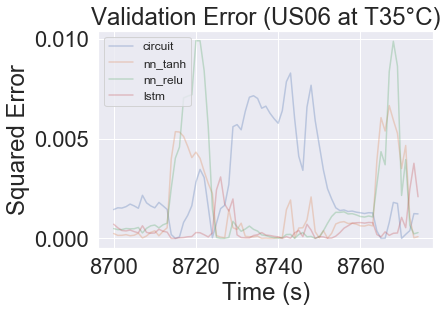

In [178]:
sns.set(font_scale=2) # plot font size
window_start = 8700
window_end = 8775
true_alpha = 0.5
other_alpha = 0.3
for dev_path in [dev_paths[1]]:
    fig, ax = plt.subplots()
    
    # ground truth
    voltage = pd.DataFrame.to_numpy(df_dev['voltage_v'][df_dev['data_path'] == dev_path])
    #plt.plot(np.arange(window_start, window_end), voltage[window_start:window_end], label='true', linewidth=4, linestyle='dashed', zorder=10, alpha=true_alpha)
    
    # circuit model
    v_oc = pd.DataFrame.to_numpy(df_dev['v_oc'][df_dev['data_path'] == dev_path])
    v_p = pd.DataFrame.to_numpy(df_dev['v_p'][df_dev['data_path'] == dev_path])
    v_i = pd.DataFrame.to_numpy(df_dev['current_a'][df_dev['data_path'] == dev_path] * r_0)
    v_hat = v_oc - v_p - (-1) * v_i 
    plt.plot(np.arange(window_start, window_end), np.power(voltage - v_hat, 2)[window_start:window_end], label='circuit', alpha=other_alpha)
    
    # linear regression
    X = X_dev[['current_a','soc']][X_dev['data_path'] == dev_path].values
    y = y_dev['voltage_v'][y_dev['data_path'] == dev_path].values
    #reg_pred = model_reg.predict(X).reshape(y.shape)
    #plt.plot(np.arange(window_start, window_end), reg_pred[window_start:window_end], label='reg', alpha=other_alpha)
    
    # nn tanh
    tanh_pred = model_nn_tanh.predict(X).reshape(y.shape)
    plt.plot(np.arange(window_start, window_end), np.power(voltage - tanh_pred, 2)[window_start:window_end], label='nn_tanh', alpha=other_alpha)
    
    # nn relu
    relu_pred = model_nn_relu.predict(X).reshape(y.shape)
    plt.plot(np.arange(window_start, window_end), np.power(voltage - relu_pred, 2)[window_start:window_end], label='nn_relu', alpha=other_alpha)
    
    # lstm
    X, y = windowed_data(X_dev[X_dev['data_path'] == dev_path],
                         y_dev[y_dev['data_path'] == dev_path],
                         lstm_window_size)
    lstm_pred = model_lstm.predict(X)
    lstm_pred_padded = np.concatenate((np.repeat(lstm_pred[0], lstm_window_size-1).reshape((lstm_window_size-1, 1)), lstm_pred), axis=0).reshape(voltage.shape)
    plt.plot(np.arange(window_start, window_end), np.power(voltage - lstm_pred_padded, 2)[window_start:window_end], label='lstm', alpha=other_alpha)

    # format plot nicely
    cycle = dev_path.split('/')[-2]
    temp = dev_path.split('/')[-3]
    clean_dev_path = cycle + " at " + temp + "°C"
    plt.title('Validation Error ({})'.format(clean_dev_path))
    plt.legend(loc='upper left', fontsize=12)
    #plt.legend(title='Model', loc='right', bbox_to_anchor=(1.75, 0.5), ncol=1)
    plt.ylabel('Squared Error')
    plt.xlabel('Time (s)')